In [147]:
from functions import *
import gmsh
import numpy as np
import meshio
import matplotlib.pyplot as plt

import contextlib
import os
from urllib.request import urlretrieve


In [148]:
# Domain parameters
seaside = 10  # Length of the domain in x-direction
roof = 13  # Length of the domain in y-direction (roof of the crownwall)
top = 10 # top of the caisson
wall = 8 # location of the left side of the crownwall
tip = 1 # tip of the crownwall


In [149]:
def GaussPoints(points=1):
    if points == 1:
        # 1-point quadrature
        qp = np.array([[1/3, 1/3]])
        weights = np.array([0.5])
    elif points == 3:
        qp = np.array([[1/6, 1/6], [2/3, 1/6], [1/6, 2/3]])
        weights = np.array([1/6, 1/6, 1/6]) 
    else:
        raise NotImplementedError("Only order 1 and 2 implemented")
    return qp, weights

# Defining af function for the creation of the shape functions
def shape_functions(qp):
    # Linear shape functions on triangle
    N = []
    dN_dxi = []
    for xi, eta in qp:
        N.append(np.array([1 - xi - eta, xi, eta]))
        dN_dxi.append(np.array([[-1, -1], [1, 0], [0, 1]]))
    return np.array(N), np.array(dN_dxi)

# Function to define the elsaticity tensor
def elasticity_tensor(E, nu, plane_stress=True):
    if plane_stress:
        C = E / (1 - nu**2) * np.array([
            [1, nu, 0],
            [nu, 1, 0],
            [0, 0, (1 - nu)/2]
        ])
    else:  # Plane strain
        C = E / ((1 + nu)*(1 - 2*nu)) * np.array([
            [1 - nu, nu, 0],
            [nu, 1 - nu, 0],
            [0, 0, (1 - 2*nu)/2]
        ])
    return C

# Function to define the element stiffness matrix
def element_stiffness(coords, C, qp, weights, dN_dxi):
    Ke = np.zeros((6, 6))
    for i, (xi_eta, w) in enumerate(zip(qp, weights)):
        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)
        invJ = np.linalg.inv(J)
        dN_dx = dN_dxi[i] @ invJ

        B = np.zeros((3, 6))
        for a in range(3):
            B[0, 2*a] = dN_dx[a, 0]
            B[1, 2*a+1] = dN_dx[a, 1]
            B[2, 2*a] = dN_dx[a, 1]
            B[2, 2*a+1] = dN_dx[a, 0]

        Ke += B.T @ C @ B * detJ * w
    return Ke

# Function to compute the element mass per element
def element_mass(coords, density, N, weights, dN_dxi):
    Me = np.zeros((6, 6))
    for i, w in enumerate(weights):
        Ni = N[i]
        Ni_matrix = np.zeros((2, 6))
        Ni_matrix[0, 0::2] = Ni
        Ni_matrix[1, 1::2] = Ni

        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)

        Me += density * (Ni_matrix.T @ Ni_matrix) * detJ * w
    return Me

def element_force(coords, body_force, N, weights, dN_dxi):
    fe = np.zeros(6)
    for i, w in enumerate(weights):
        Ni = N[i]
        J = coords.T @ dN_dxi[i]
        detJ = np.linalg.det(J)
        for a in range(3):
            fe[2*a] += Ni[a] * body_force[0] * detJ * w
            fe[2*a+1] += Ni[a] * body_force[1] * detJ * w
    return fe


def assemble(mesh, elements, coords, C, density, body_force):
    # Calculate the total number of degrees of freedom (DOFs)
    num_dofs = coords.shape[0] * 2

    # Initialize global stiffness matrix, mass matrix, and force vector
    K = np.zeros((num_dofs, num_dofs))  # Stiffness matrix
    M = np.zeros((num_dofs, num_dofs))  # Mass matrix
    f = np.zeros(num_dofs)  # Force vector

    # Get quadrature points and weights for the triangle element
    qp, weights = GaussPoints()

    # Get shape functions and their derivatives in reference coordinates
    N, dN_dxi = shape_functions(qp)

    # Loop over all elements in the mesh
    for elem in elements:
        # Extract coordinates of the nodes for this element
        nodal_coords = coords[elem]
        
        # Define the degrees of freedom (DOFs) corresponding to the element's nodes
        dofs = np.array([[2*n, 2*n+1] for n in elem]).flatten()

        # Compute element stiffness matrix (Ke), mass matrix (Me), and force vector (fe)
        Ke = element_stiffness(nodal_coords, C, qp, weights, dN_dxi)
        Me = element_mass(nodal_coords, density, N, weights, dN_dxi)
        fe = element_force(nodal_coords, body_force, N, weights, dN_dxi)

        # Assemble element contributions into global matrices and vector
        for i in range(6):
            for j in range(6):
                # Add the contributions to the global stiffness and mass matrices
                K[dofs[i], dofs[j]] += Ke[i, j]
                M[dofs[i], dofs[j]] += Me[i, j]
            
            # Add the force vector contributions to the global force vector
            f[dofs[i]] += fe[i]
    
    # Return the assembled global stiffness matrix, mass matrix, and force vector
    return K, M, f

In [150]:
gmsh.initialize()
gmsh.model.add("Breakwater")

# Tag offset
tag = 1

# Mesh size
lc_arc = 1
lc_block = 1

p_center = gmsh.model.geo.addPoint(seaside+tip, roof-2*tip, 0, lc_arc, tag); tag += 1

# Outer rectangle points
p1 = gmsh.model.geo.addPoint(0, 0, 0, lc_block, tag); tag += 1
p2 = gmsh.model.geo.addPoint(0, top, 0, lc_block, tag); tag += 1
p3 = gmsh.model.geo.addPoint(wall, top, 0, lc_arc, tag); tag += 1
p4 = gmsh.model.geo.addPoint(wall, roof, 0, lc_arc, tag); tag += 1
p5 = gmsh.model.geo.addPoint(seaside+tip, roof, 0, lc_arc, tag); tag += 1
p6 = gmsh.model.geo.addPoint(seaside+tip, roof-tip, 0, lc_arc, tag); tag += 1
p7 = gmsh.model.geo.addPoint(seaside, roof-2*tip, 0, lc_arc, tag); tag += 1
p8 = gmsh.model.geo.addPoint(seaside, 0, 0, lc_block, tag); tag += 1

# Outer rectangle lines
l_a = gmsh.model.geo.addLine(p1, p2)
l_b = gmsh.model.geo.addLine(p2, p3)
l_c = gmsh.model.geo.addLine(p3, p4)
l_d = gmsh.model.geo.addLine(p4, p5)
l_e = gmsh.model.geo.addLine(p5, p6)
l_f = gmsh.model.geo.addCircleArc(p6, p_center, p7)
l_g = gmsh.model.geo.addLine(p7, p8)
l_h = gmsh.model.geo.addLine(p8, p1)


# Define surface with a hole
outer_loop = gmsh.model.geo.addCurveLoop([l_a, l_b, l_c, l_d, l_e, l_f, l_g, l_h])
surface = gmsh.model.geo.addPlaneSurface([outer_loop])

gmsh.model.geo.synchronize()

# # Define physical group for the interior domain
interior_tag = 3  # Assign a physical group ID
gmsh.model.addPhysicalGroup(2, [surface], interior_tag)  # 2 corresponds to surface dimension

# # Define physical boundary for the left vertical side (l4)
left_side_tag = 2  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_h], left_side_tag)  # 1 corresponds to curve dimension

right_side_tag = 1  # Assign a physical group ID
gmsh.model.addPhysicalGroup(1, [l_f, l_g, l_e], right_side_tag)  # 1 corresponds to curve dimension



# Generate the mesh
# gmsh.model.geo.synchronize()
gmsh.model.mesh.generate(2)
gmsh.write("Breakwater.msh")


hor_edges [[ 7 39]
 [39 40]
 [40 41]
 [41 42]
 [42 43]
 [43 44]
 [44 45]
 [45 46]
 [46 47]
 [47  0]]
ver_edges [[ 4  5]
 [ 5 28]
 [28  6]
 [ 6 29]
 [29 30]
 [30 31]
 [31 32]
 [32 33]
 [33 34]
 [34 35]
 [35 36]
 [36 37]
 [37 38]
 [38  7]]


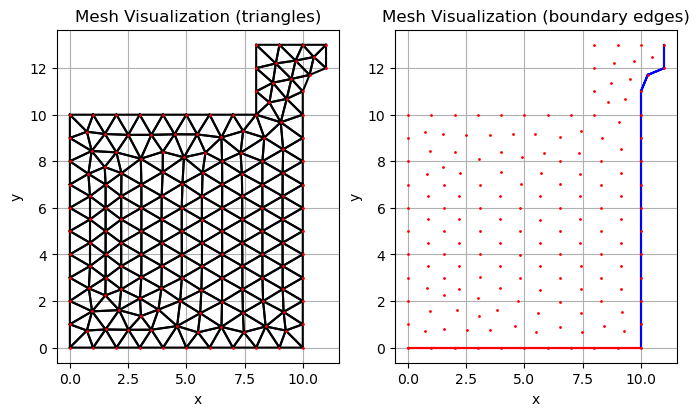

In [151]:
# Read mesh from file
mesh = meshio.read("Breakwater.msh")

# Extract node coordinates and triangle connectivity
points = mesh.points[:, :2]  # (x, y)
triangles = mesh.get_cells_type("triangle")
groups = mesh.get_cell_data("gmsh:physical", "line")
# edges = mesh.get_cells_type("line") # edges on the left boundary
# edges = mesh.cells_dict.get(2, [])  # edges on the left boundary
hor_edges = mesh.get_cells_type("line")[groups == left_side_tag]
ver_edges = mesh.get_cells_type("line")[groups == right_side_tag]
print("hor_edges", hor_edges)
print("ver_edges", ver_edges)

# Plot triangles
fig, ax = plt.subplots(1,2, figsize=(8, 8))
for tri in triangles:
    coords = points[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    ax[0].plot(coords[:, 0], coords[:, 1], 'k-')
ax[0].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[0].set_aspect('equal')
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")
ax[0].set_title("Mesh Visualization (triangles)")
ax[0].grid(True)

# Plot edges
for edge in ver_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'blue', label = "ver")
for edge in hor_edges:
    coords = points[edge]
    coords = np.vstack((coords, coords[0]))  # close the line
    ax[1].plot(coords[:, 0], coords[:, 1], 'red', label = "hor")
ax[1].plot(points[:, 0], points[:, 1], 'ro', markersize=1)
ax[1].set_aspect('equal')
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")
ax[1].set_title("Mesh Visualization (boundary edges)")
ax[1].grid(True)
plt.show()


In [152]:
# #Testing Triangle

# def f(x, y):
#     return x * y

# gps1, weights1 = GaussPoints(1)
# int1 = sum(f(gps1[i, 0], gps1[i, 1]) * weights1[i] for i in range(len(weights1)))
# print("Integral of f(x,y) over the triangle", int1, "should be:", 1/24)

# gps3, weights3 = GaussPoints(3)
# int3 = sum(f(gps3[i, 0], gps3[i, 1]) * weights3[i] for i in range(len(weights3)))
# print("Integral of f(x,y) over the triangle", int3, "should be:", 1/24)


In [153]:
# Problem parameters
E = 36e9  # Young's modulus in Pa
nu = 0.3  # Poisson's ratio
density = 2500  # Density in kg/m^3
# body_force = np.array([0, -9.81 * density])  # Body force (gravity)
body_force = np.array([0, 0])  # Body force (gravity)
C = elasticity_tensor(E, nu)
Force = 1

# Assemble the global stiffness matrix, mass matrix, and force vector
K, M, f = assemble(mesh, triangles, points, C, density, body_force)

# Apply boundary conditions
# For simplicity, we will apply Dirichlet boundary conditions on the left side (l4). The value of u_dir is set to 0.
u_dir = 0
Force = 1

# Find the nodes on the left boundary (l4)
hor_boundary_nodes = np.where(np.isin(points[:, 1], points[hor_edges[:, 1], 0]))[0]
hor_boundary_dofs = np.array([[2*n, 2*n+1] for n in hor_boundary_nodes]).flatten()
print("hor_boundary_nodes", hor_boundary_nodes)
print(points[hor_edges[:, 0],0])

ver_boundary_nodes = np.where(np.isin(points[:, 0], points[ver_edges[:, 0], 0]))[0]
ver_boundary_dofs = np.array([[2*n, 2*n+1] for n in ver_boundary_nodes]).flatten()

ver_boundary_nodes = np.unique(ver_edges.flatten())
ver_boundary_dofs = np.array([[2*n, 2*n+1] for n in ver_boundary_nodes]).flatten()

print("hor_boundary_dofs", hor_boundary_dofs)
print("ver_boundary_dofs", ver_boundary_dofs)

ver_boundary_dofs = ver_boundary_dofs[~np.isin(ver_boundary_dofs, hor_boundary_dofs)]

# Set the corresponding rows and columns of K and M to zero

for dof in hor_boundary_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[dof, dof] = 1  # Set the diagonal to 1
    M[dof, :] = 0  # Set the row to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = u_dir  # Set the force vector to 
    
for dof in ver_boundary_dofs:
    K[dof, :] = 0  # Set the row to zero
    K[dof, dof] = 1  # Set the diagonal to 1
    M[dof, :] = 0  # Set the row to zero
    M[dof, dof] = 1  # Set the diagonal to 1
    f[dof] = -1e-3  # Set the force vector to
    




print(f)


hor_boundary_nodes [ 0  7 39 40 41 42 43 44 45 46 47]
[10.  9.  8.  7.  6.  5.  4.  3.  2.  1.]
hor_boundary_dofs [ 0  1 14 15 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95]
ver_boundary_dofs [ 8  9 10 11 12 13 14 15 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77]
[ 0.     0.     0.     0.     0.     0.     0.     0.    -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001  0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.    -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001
 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001 -0.001  0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.
  0.     0.     0.

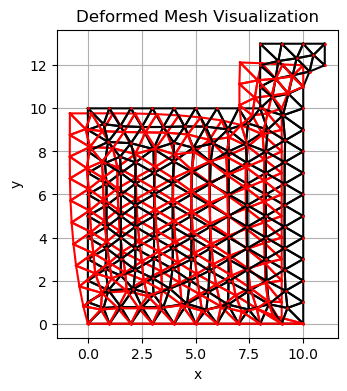

In [154]:
# Solve the system of equations
u = np.linalg.solve(K, f)

# Reshape the solution vector into a 2D array for visualization and magnify by 1e3
u_reshaped = u.reshape(-1, 2) * 1e3

# Plot the deformed mesh
plt.figure(figsize=(8, 4))
for tri in triangles:
    coords = points[tri]
    coords_displaced = coords + u_reshaped[tri]
    coords = np.vstack((coords, coords[0]))  # close the triangle
    coords_displaced = np.vstack((coords_displaced, coords_displaced[0]))  # close the triangle
    plt.plot(coords[:, 0], coords[:, 1], 'k-')
    plt.plot(coords_displaced[:,0],coords_displaced[:,1], 'r-')
plt.plot(points[:, 0], points[:, 1], 'ro', markersize=1)
plt.gca().set_aspect('equal')
plt.xlabel("x")
plt.ylabel("y")
plt.title("Deformed Mesh Visualization")
plt.grid(True)
plt.show()